In [1]:
import os
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

from qiskit import QuantumCircuit
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.visualization import plot_error_map

from qiskit_aer.primitives import SamplerV2 as AERSamplerV2

from qiskit_ibm_runtime.fake_provider import FakeLondonV2, FakeMelbourneV2, FakeAlmadenV2 
from qiskit_ibm_runtime import SamplerV2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from utils import export_data_json, generate_output_dir, generate_full_file_path, import_json_data

In [2]:
OUTPUT_PATH = os.path.join(os.getcwd(), 'ghz-test')
generate_output_dir(OUTPUT_PATH)

/home/alexandre/projects/scientific-research-2-qec-and-qem/src/ghz-test already exists!


In [3]:
SHOTS = 1000

In [4]:
london = FakeLondonV2()
melbourne = FakeMelbourneV2()
almaden = FakeAlmadenV2()

print("Number of qubits per baceknd")
print(f"London V2: {london.num_qubits}")
print(f"Melbourne V2: {melbourne.num_qubits}")
print(f"Almaden V2: {almaden.num_qubits}")

Number of qubits per baceknd
London V2: 5
Melbourne V2: 15
Almaden V2: 20


In [5]:
_5_qubits = london
_15_qubits = melbourne
_20_qubits = almaden

London Coupling map and error map


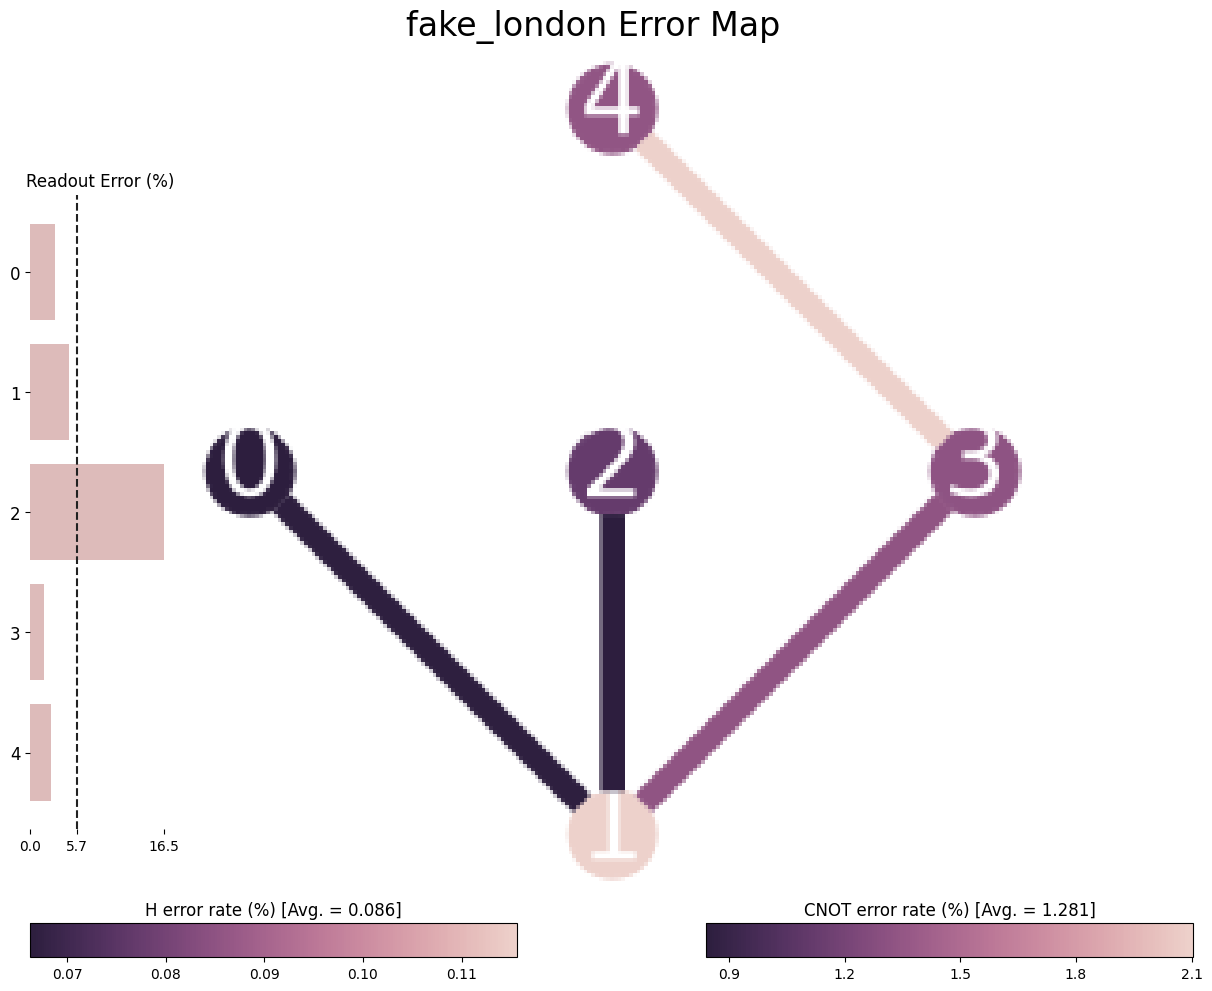

In [7]:
print("London Coupling map and error map")
fig = plot_error_map(_5_qubits)
fig.savefig(generate_full_file_path(OUTPUT_PATH, "error-map-london-v2-backend.png"))
display(fig)

Melbourne Coupling map and error map


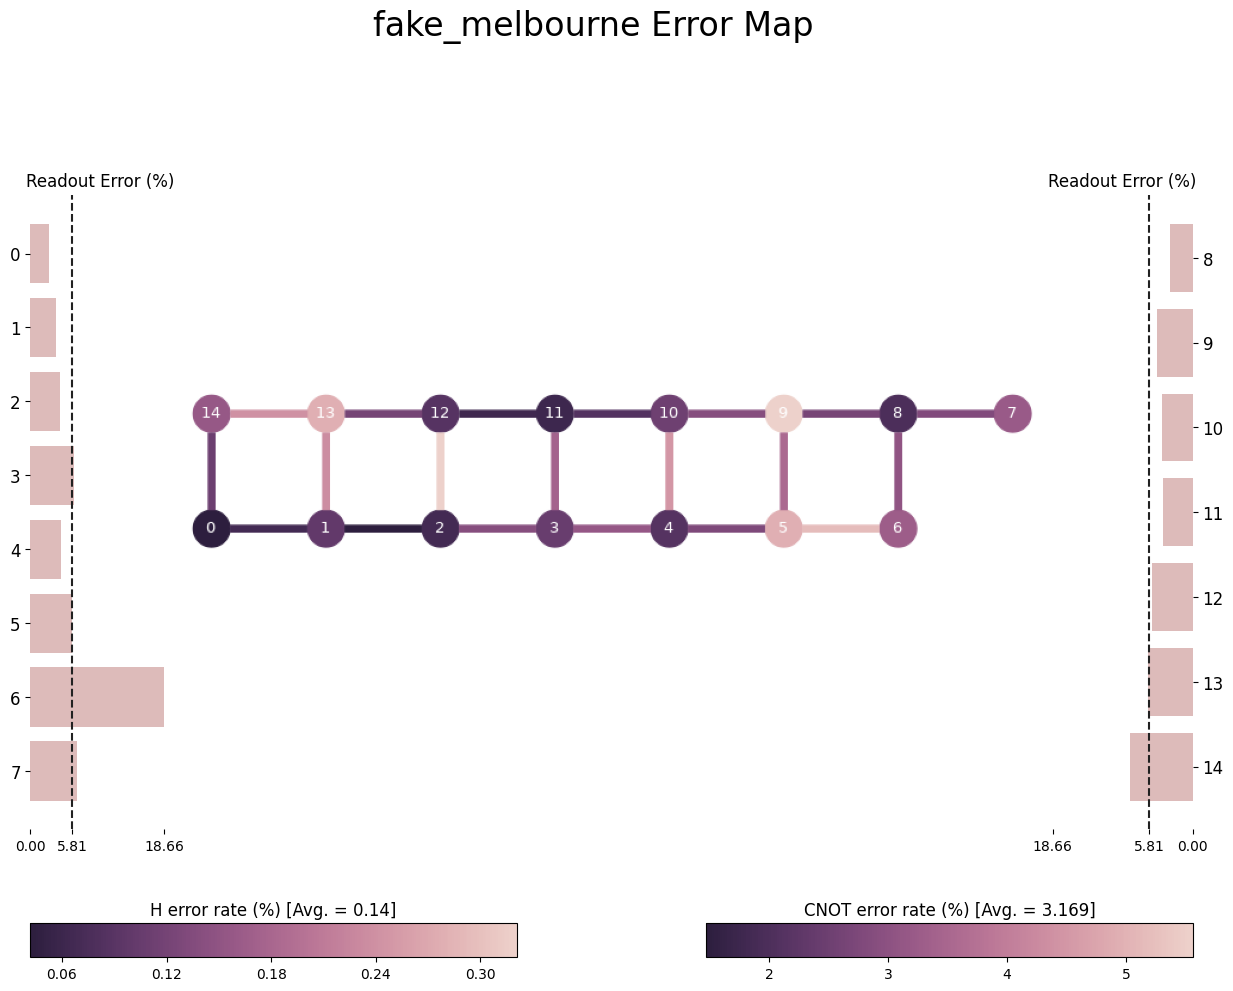

In [8]:
print("Melbourne Coupling map and error map")
fig = plot_error_map(_15_qubits)
fig.savefig(generate_full_file_path(OUTPUT_PATH, "error-map-melbourne-v2-backend.png"))
display(fig)

Almaden Coupling map


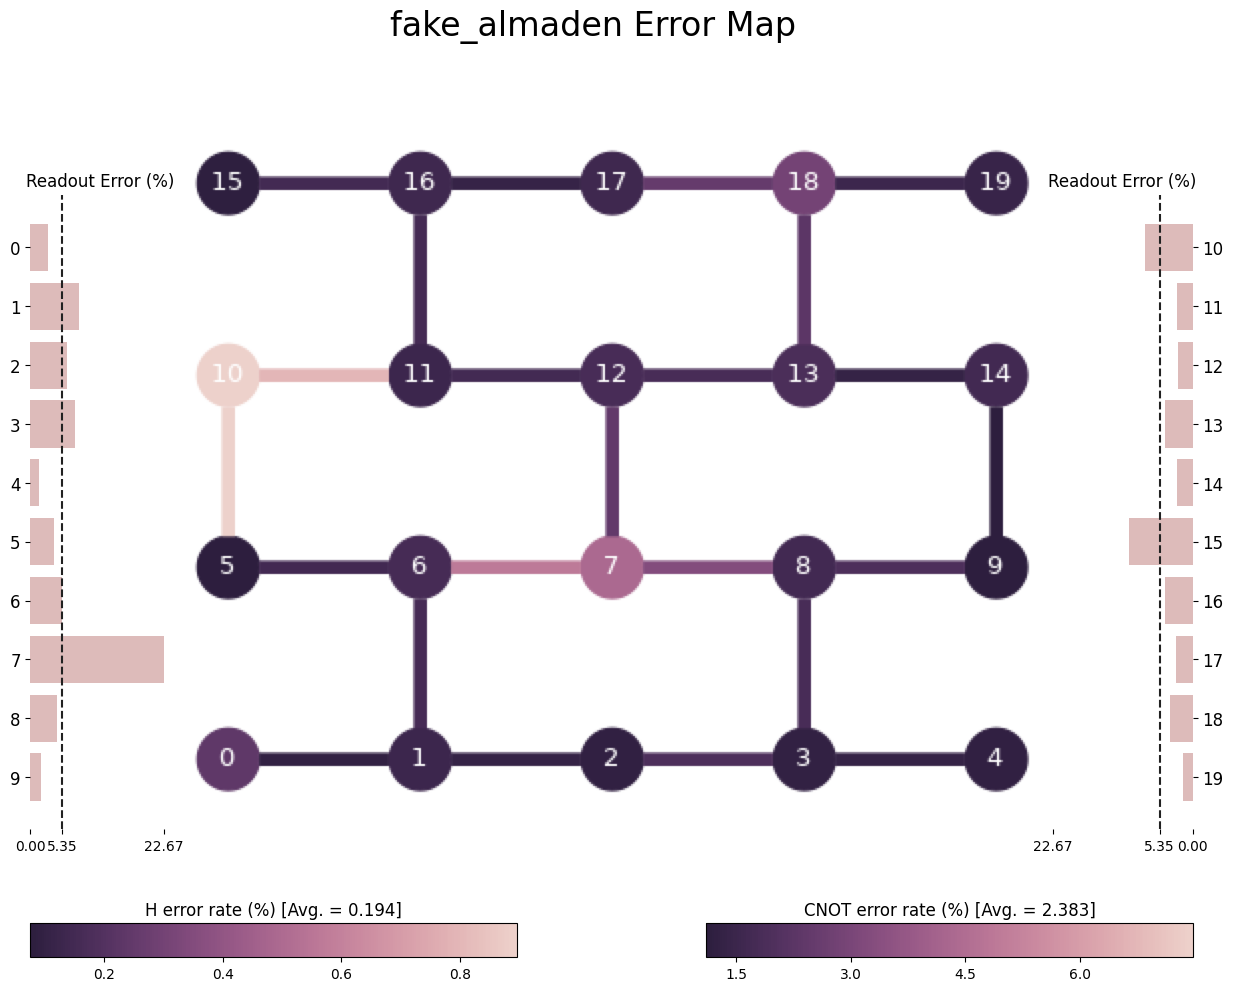

In [9]:
print("Almaden Coupling map")
fig = plot_error_map(_20_qubits)
fig.savefig(generate_full_file_path(OUTPUT_PATH, "error-map-almaden-v2-backend.png"))
display(fig)

In [6]:
def generate_simple_ghz(n_qubits):
    qc = QuantumCircuit(n_qubits)
    qc.h(0)
    for i in range(n_qubits-1):
        qc.cx(i, i+1)
    qc.measure_all()

    return qc

In [7]:
def amount_of_errors_ghz(results):
    errors = {
        "correct":0,
        "wrong":0
    }

    size = len(list(results.keys())[0])
    target_bitstrings = ('0'*size, '1'*size)

    for target in target_bitstrings:
        from_data = results.get(target)
        errors["correct"] += results[target] if from_data is not None else 0

    errors['wrong'] = SHOTS - errors["correct"]
    
    return errors

In [8]:
def get_counts(circuit, baceknd, opt=0):
    pm = generate_preset_pass_manager(optimization_level=opt, backend=baceknd)
    sampler = AERSamplerV2(options={"backend_options":{'method':'statevector','device':'GPU'}}).from_backend(backend)

    isa_qc = pm.run(circuit)
    return sampler.run([isa_qc], shots=SHOTS).result()[0].data.meas.get_counts()

In [9]:
ghz_circuits = [
    generate_simple_ghz(5),
    generate_simple_ghz(15),
    generate_simple_ghz(20)
]

In [10]:
backends = [
    _5_qubits,
    _15_qubits,
    _20_qubits
]

In [11]:
get_result_path = lambda n_qubits, backend_name: generate_full_file_path(OUTPUT_PATH, f"results-no-mitigation-{backend_name}-with-{n_qubits}-qubits.json")

In [ ]:
experiments_results = []
for index, (circuit, backend) in enumerate(zip(ghz_circuits, backends)):
    n_qubits = backend.num_qubits
    backend_name = backend.name

    print(f"Running {index+1} experiment on {backend_name} with {n_qubits} qubits")
    results = get_counts(circuit,backend)
    export_data_json(results, get_result_path(n_qubits, backend_name))
    experiments_results.append(results)

Running 1 experiment on fake_london with 5 qubits
saving /home/alexandre/projects/scientific-research-2-qec-and-qem/src/ghz-test/results-no-mitigation-fake_london-with-5-qubits.json...
Running 2 experiment on fake_melbourne with 15 qubits
saving /home/alexandre/projects/scientific-research-2-qec-and-qem/src/ghz-test/results-no-mitigation-fake_melbourne-with-15-qubits.json...
Running 3 experiment on fake_almaden with 20 qubits
saving /home/alexandre/projects/scientific-research-2-qec-and-qem/src/ghz-test/results-no-mitigation-fake_almaden-with-20-qubits.json...


---

In [22]:
amount_of_errors = pd.DataFrame(columns=['label', 'errors'])

for i,backend in enumerate(backends):
    backend_name = backend.name
    n_qubits = backend.num_qubits

    file_path = get_result_path(n_qubits, backend_name)
    data = import_json_data(file_path)
    errors = amount_of_errors_ghz(data)
    print(errors)

    label = f'{backend_name} - {n_qubits} qubits'
    amount_of_errors.loc[i] = {'label':label, 'errors':errors['wrong']}

    export_data_json(errors, generate_full_file_path(OUTPUT_PATH, f"amount-of-errors-no-mitigation-{backend_name}-with-{n_qubits}-qubits.json"))

Getting data from: /home/alexandre/projects/scientific-research-2-qec-and-qem/src/ghz-test/results-no-mitigation-fake_london-with-5-qubits.json
{'correct': 716, 'wrong': 284}
saving /home/alexandre/projects/scientific-research-2-qec-and-qem/src/ghz-test/amount-of-errors-no-mitigation-fake_london-with-5-qubits.json...
Getting data from: /home/alexandre/projects/scientific-research-2-qec-and-qem/src/ghz-test/results-no-mitigation-fake_melbourne-with-15-qubits.json
{'correct': 288, 'wrong': 712}
saving /home/alexandre/projects/scientific-research-2-qec-and-qem/src/ghz-test/amount-of-errors-no-mitigation-fake_melbourne-with-15-qubits.json...
Getting data from: /home/alexandre/projects/scientific-research-2-qec-and-qem/src/ghz-test/results-no-mitigation-fake_almaden-with-20-qubits.json
{'correct': 110, 'wrong': 890}
saving /home/alexandre/projects/scientific-research-2-qec-and-qem/src/ghz-test/amount-of-errors-no-mitigation-fake_almaden-with-20-qubits.json...


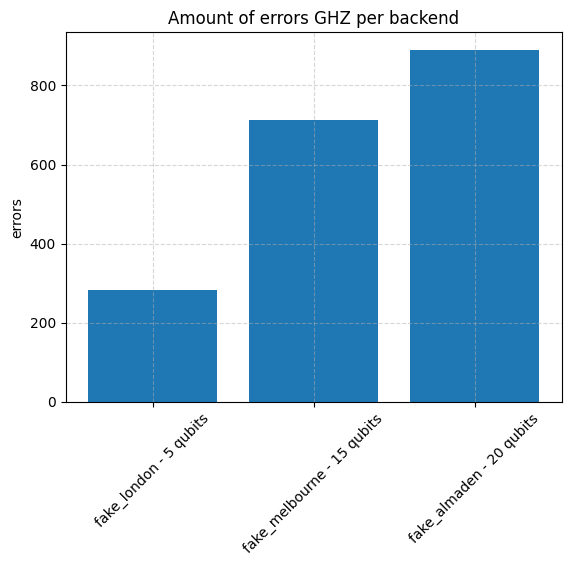

In [23]:
fig, ax = plt.subplots()
ax.bar(x="label", height="errors", data=amount_of_errors)
ax.grid(linestyle="--",alpha=0.5,zorder=1)
ax.set_title("Amount of errors GHZ per backend")
ax.set_ylabel("errors")
ax.tick_params(axis='x', rotation=45)
plt.savefig(generate_full_file_path(OUTPUT_PATH, "amount-of-errors-no-mitigation-fackbackends-ghz.png"), bbox_inches='tight')
plt.show()

In [24]:
get_result_path_mitigation = lambda n_qubits, backend_name: generate_full_file_path(OUTPUT_PATH, f"results-mitigation-3-{backend_name}-with-{n_qubits}-qubits.json")
get_errors_path_mitigation = lambda n_qubits, backend_name: generate_full_file_path(OUTPUT_PATH, f"errors-mitigation-3-{backend_name}-with-{n_qubits}-qubits.json")

In [ ]:
for index, (circuit, backend) in enumerate(zip(ghz_circuits, backends)):
    n_qubits = backend.num_qubits
    backend_name = backend.name

    print(f"Running {index+1} experiment on {backend_name} with {n_qubits} qubits (mitigation level=3)")

    results = get_counts(circuit,backend,opt=3)
    export_data_json(results, get_result_path_mitigation(n_qubits, backend_name))

    errors = amount_of_errors_ghz(results)
    export_data_json(errors, get_errors_path_mitigation(n_qubits, backend_name))

Running 1 experiment on fake_london with 5 qubits (mitigation level=3)
saving /home/alexandre/projects/scientific-research-2-qec-and-qem/src/ghz-test/results-mitigation-3-fake_london-with-5-qubits.json...
saving /home/alexandre/projects/scientific-research-2-qec-and-qem/src/ghz-test/errors-mitigation-3-fake_london-with-5-qubits.json...
Running 2 experiment on fake_melbourne with 15 qubits (mitigation level=3)
saving /home/alexandre/projects/scientific-research-2-qec-and-qem/src/ghz-test/results-mitigation-3-fake_melbourne-with-15-qubits.json...
saving /home/alexandre/projects/scientific-research-2-qec-and-qem/src/ghz-test/errors-mitigation-3-fake_melbourne-with-15-qubits.json...
Running 3 experiment on fake_almaden with 20 qubits (mitigation level=3)
saving /home/alexandre/projects/scientific-research-2-qec-and-qem/src/ghz-test/results-mitigation-3-fake_almaden-with-20-qubits.json...
saving /home/alexandre/projects/scientific-research-2-qec-and-qem/src/ghz-test/errors-mitigation-3-fake

---

In [25]:
amount_of_errors_mitigation = pd.DataFrame(columns=['label', 'errors'])

for i,backend in enumerate(backends):
    backend_name = backend.name
    n_qubits = backend.num_qubits

    errors = import_json_data(get_errors_path_mitigation(n_qubits, backend_name))
    print(errors)

    label = f'{backend_name} - {n_qubits} qubits'
    amount_of_errors_mitigation.loc[i] = {'label':label, 'errors':errors['wrong']}

Getting data from: /home/alexandre/projects/scientific-research-2-qec-and-qem/src/ghz-test/errors-mitigation-3-fake_london-with-5-qubits.json
{'correct': 711, 'wrong': 289}
Getting data from: /home/alexandre/projects/scientific-research-2-qec-and-qem/src/ghz-test/errors-mitigation-3-fake_melbourne-with-15-qubits.json
{'correct': 294, 'wrong': 706}
Getting data from: /home/alexandre/projects/scientific-research-2-qec-and-qem/src/ghz-test/errors-mitigation-3-fake_almaden-with-20-qubits.json
{'correct': 210, 'wrong': 790}


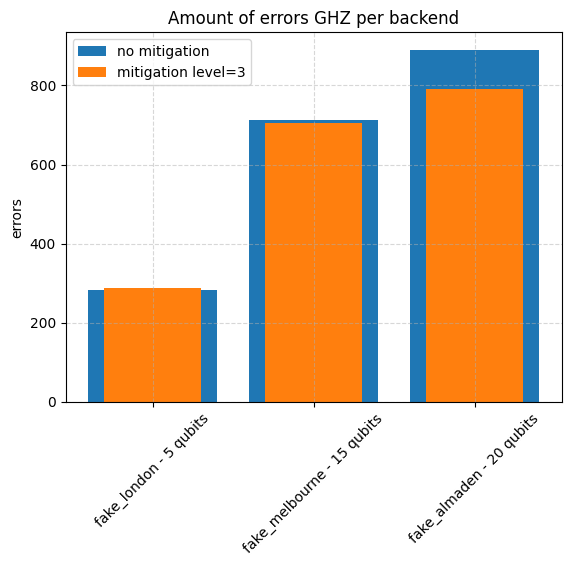

In [30]:
fig, ax = plt.subplots()
ax.bar(x="label", height="errors", data=amount_of_errors)
ax.bar(x="label", height="errors", data=amount_of_errors_mitigation, width=0.6)
ax.legend(['no mitigation', 'mitigation level=3'])
ax.grid(linestyle="--",alpha=0.5,zorder=1)
ax.set_title("Amount of errors GHZ per backend")
ax.set_ylabel("errors")
ax.tick_params(axis='x', rotation=45)
plt.savefig(generate_full_file_path(OUTPUT_PATH, "amount-of-errors-no-mitigation-fackbackends-ghz-compartion-between-no-migation-and-mitigation-3.png"), bbox_inches='tight')
plt.show()